In [29]:
# SECTION 1: SETUP & IMPORTS

# Core ML
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
import warnings
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler


# System and Warnings
import warnings
warnings.filterwarnings("ignore")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [30]:
# Configurations
IMG_SIZE = 128
VOLUME_SLICES = 50
VOLUME_START_AT = 22
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_ROUNDS = 10
batch_size = 32  # stable
pin_memory = True
num_workers = 4  # or os.cpu_count() // 2


In [31]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.patient_dirs = sorted(os.listdir(root_dir))
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_id = self.patient_dirs[idx]
        patient_path = os.path.join(self.root_dir, patient_id)

        # Detect available modality naming pattern
        available_files = os.listdir(patient_path)
        available_files_lower = [f.lower() for f in available_files]

        if any('flair' in f for f in available_files_lower):
            # BraTS19/21 style
            modality_map = {
                "flair": f"{patient_id}_flair.nii",
                "t1": f"{patient_id}_t1.nii",
                "t1ce": f"{patient_id}_t1ce.nii",
                "t2": f"{patient_id}_t2.nii",
            }
        elif any('t2w' in f for f in available_files_lower):
            # BraTS-GLI 2023 style
            modality_map = {
                "t1c": f"{patient_id}-t1c.nii",
                "t1n": f"{patient_id}-t1n.nii",
                "t2f": f"{patient_id}-t2f.nii",
                "t2w": f"{patient_id}-t2w.nii",
            }
        else:
            raise FileNotFoundError(f"Unknown modality pattern for patient {patient_id}")

        # Load modalities
        image_data = []
        for mod_key, mod_filename in modality_map.items():
            full_path = os.path.join(patient_path, mod_filename)
            if not os.path.exists(full_path):
                raise FileNotFoundError(f"Missing file: {full_path}")
            image = nib.load(full_path).get_fdata()
            image_data.append(image)

        image_np = np.stack(image_data, axis=0).astype(np.float32)
        image_tensor = torch.tensor(image_np, dtype=torch.float32)

        # Load label (segmentation)
        # After loading image modalities
        # Now find label file
        label_tensor = None
        for f in available_files:
            if patient_id.split("_")[0] in f and 'seg' in f.lower():
                label_path = os.path.join(patient_path, f)
                label_np = nib.load(label_path).get_fdata().astype(np.uint8)
                label_np[label_np == 4] = 3  # remap 4→3
                label_tensor = torch.from_numpy(label_np).long().unsqueeze(0)
                break

        if self.train and label_tensor is None:
            raise FileNotFoundError(f"No segmentation label found for patient {patient_id}")


        # Apply transform
        if self.transform:
            subject_dict = {"images": tio.ScalarImage(tensor=image_tensor)}
            if label_tensor is not None:
                subject_dict["label"] = tio.LabelMap(tensor=label_tensor)
            subject = tio.Subject(**subject_dict)
            transformed = tio.Compose([self.transform])(subject)
            image_tensor = transformed.images.data
            if label_tensor is not None:
                label_tensor = transformed.label.data

        return (image_tensor, label_tensor) if label_tensor is not None else (image_tensor, None)


In [32]:
# CELL 3: TorchIO Preprocessing Transform

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensities to [0, 1]
    tio.Resize((128, 128, 128)),               # Resize to fixed shape
    tio.ZNormalization()                       # Normalize mean=0, std=1
])


In [33]:
augment_transform = tio.Compose([
    # Intensity-based
    tio.RandomBiasField(p=0.3),
    tio.RandomGamma(p=0.3),
    tio.RandomNoise(p=0.2),
    
    # Spatial-based
    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=10,
        translation=5,
        center='image',
        p=0.5
    ),
    tio.RandomElasticDeformation(p=0.2),
    tio.RandomFlip(axes=('LR',), p=0.5),

    # Preprocessing
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((128, 128, 128)),
    tio.ZNormalization()
])


In [57]:
# CELL 4: Client Dataset Paths and Loaders

# Define paths (adjust as needed to match your directory structure)
Hospital1_Train = 'Data/2023GLI/TrainingData'
Hospital1_Val   = 'Data/2023GLI/ValidationData'
Hospital2_Train = 'Data/2023MEN/TrainingData'
Hospital2_Val   = 'Data/2023MEN/ValidationData'
Hospital3_Train = 'Data/2023MET/TrainingData'
Hospital3_Val   = 'Data/2023MET/ValidationData'
Hospital4_Train = 'Data/2023PED/TrainingData'
Hospital4_Val   = 'Data/2023PED/ValidationData'
Hospital5_Train = 'Data/2023SSA/TrainingData'
Hospital5_Val   = 'Data/2023SSA/ValidationData'
Hospital6_Train_Val = 'Data/BraTS2021'
Hospital7_Train = 'Data/BraTS2020/TrainingData'
Hospital7_Val   = 'Data/BraTS2020/ValidationData'
Hospital8_Train_Val = 'Data/BraTS2019/HGG'
Hospital9_Train_Val = 'Data/BraTS2019/LGG'

hospitals = {
    "Hospital1": {"combined": Hospital1_Train},
    "Hospital2": {"combined": Hospital2_Train},
    "Hospital3": {"combined": Hospital3_Train},
    "Hospital4": {"combined": Hospital4_Train},
    "Hospital5": {"combined": Hospital5_Train},
    "Hospital6": {"combined": Hospital6_Train_Val},
    "Hospital7": {"combined": Hospital7_Train},
    "Hospital8": {"combined": Hospital8_Train_Val},
    "Hospital9": {"combined": Hospital9_Train_Val}
}

hospital_loaders = {}
train_ratio = 0.8

for hospital, paths in hospitals.items():
    print(f"🔁 Loading {hospital}...")

    if "combined" in paths or hospital in ["Hospital1", "Hospital2", "Hospital3", "Hospital4", "Hospital5", "Hospital7"]:
        # Random split from TrainingData
        dataset_path = paths["combined"]

        full_dataset = BraTSDataset(dataset_path, transform=transform, train=True)
        train_size = int(train_ratio * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])


    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

    hospital_loaders[hospital] = {
        "train": train_loader,
        "val": val_loader
    }


print("\n✅ All hospital loaders are ready.")


🔁 Loading Hospital1...
🔁 Loading Hospital2...
🔁 Loading Hospital3...
🔁 Loading Hospital4...
🔁 Loading Hospital5...
🔁 Loading Hospital6...
🔁 Loading Hospital7...
🔁 Loading Hospital8...
🔁 Loading Hospital9...

✅ All hospital loaders are ready.


Input shape: torch.Size([1, 4, 128, 128, 128]) | Label shape: torch.Size([1, 1, 128, 128, 128])


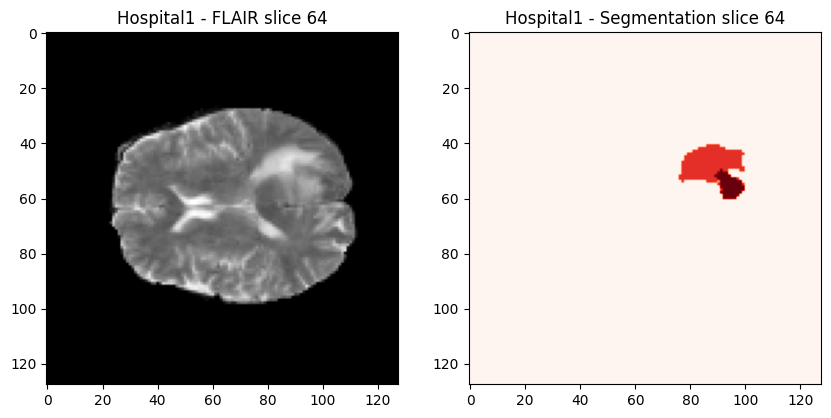

In [58]:
# CELL 5: Visualize Sample Volume + Mask Slice

import random

def visualize_random_sample(hospital="Hospital1", slice_idx=64):
    loader = hospital_loaders[hospital]["val"]
    image, label = next(iter(loader))

    print(f"Input shape: {image.shape} | Label shape: {label.shape}")
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Show slice from FLAIR (assume channel 3)
    axs[0].imshow(image[0, 3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{hospital} - FLAIR slice {slice_idx}")

    # Corresponding segmentation mask slice
    axs[1].imshow(label[0, 0, :, :, slice_idx].cpu(), cmap='Reds')
    axs[1].set_title(f"{hospital} - Segmentation slice {slice_idx}")

    plt.show()

# Example call
visualize_random_sample("Hospital1", slice_idx=64)


In [59]:
print("\n📊 Dataset sizes per hospital:")
for hospital, loaders in hospital_loaders.items():
    train_size = len(loaders['train'].dataset)
    val_size = len(loaders['val'].dataset)
    print(f"{hospital} → Train: {train_size} | Val: {val_size}")



📊 Dataset sizes per hospital:
Hospital1 → Train: 1000 | Val: 251
Hospital2 → Train: 800 | Val: 200
Hospital3 → Train: 132 | Val: 33
Hospital4 → Train: 79 | Val: 20
Hospital5 → Train: 48 | Val: 12
Hospital6 → Train: 1000 | Val: 251
Hospital7 → Train: 295 | Val: 74
Hospital8 → Train: 207 | Val: 52
Hospital9 → Train: 60 | Val: 16


In [60]:
# CELL 7: Fixed TwinSegNet Model (ViT + UNet Hybrid)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Resize skip connection if needed
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='trilinear', align_corners=False)
        x = torch.cat((x, skip), dim=1)
        return self.conv(x)


class PatchEmbedViT(nn.Module):
    def __init__(self, in_channels=128, embed_dim=256, patch_size=2):
        super(PatchEmbedViT, self).__init__()
        self.patch_embed = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, embed_dim, 1, 1, 1))  # minimal shape

    def forward(self, x):
        x = self.patch_embed(x)
        if x.shape[2:] != self.pos_embed.shape[2:]:
            pos_embed = F.interpolate(self.pos_embed, size=x.shape[2:], mode='trilinear', align_corners=False)
        else:
            pos_embed = self.pos_embed
        return x + pos_embed


class TwinSegNet(nn.Module):
    def __init__(self, in_channels=4, n_classes=3, base_channels=32):
        super(TwinSegNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, base_channels)              # 128
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)        # 64
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)    # 32
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = ConvBlock(base_channels * 4, base_channels * 8)    # 16
        self.pool4 = nn.MaxPool3d(2)

        # ViT at bottleneck
        self.vit = PatchEmbedViT(in_channels=base_channels * 8, embed_dim=base_channels * 16, patch_size=2)
        self.vit_proj = nn.Conv3d(base_channels * 16, base_channels * 8, kernel_size=1)

        # Decoder (UNet-style)
        self.up4 = UpBlock(base_channels * 8, base_channels * 4, base_channels * 4)  # match enc3
        self.up3 = UpBlock(base_channels * 4, base_channels * 2, base_channels * 2)  # match enc2
        self.up2 = UpBlock(base_channels * 2, base_channels, base_channels)          # match enc1
        self.final_conv = nn.Conv3d(base_channels, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)                # [B, 32, 128,128,128]
        e2 = self.enc2(self.pool1(e1))   # [B, 64, 64,64,64]
        e3 = self.enc3(self.pool2(e2))   # [B, 128, 32,32,32]
        e4 = self.enc4(self.pool3(e3))   # [B, 256, 16,16,16]
        b = self.pool4(e4)               # [B, 256, 8,8,8]

        b = self.vit(b)                  # [B, 512, 4,4,4] → [B, 256, 4,4,4]
        b = self.vit_proj(b)             # [B, 256, 4,4,4]

        d4 = self.up4(b, e3)             # [B, 128, 8,8,8]
        d3 = self.up3(d4, e2)            # [B, 64, 16,16,16]
        d2 = self.up2(d3, e1)            # [B, 32, 32,32,32]
        out = self.final_conv(d2)        # [B, n_classes, 32,32,32]

        return out


In [61]:
def dice_loss(pred, target, epsilon=1e-6):
    """
    pred: (B, C, D, H, W)
    target: (B, 1, D', H', W') → label mask
    """
    pred = torch.softmax(pred, dim=1)

    # Resize target to match pred spatial shape
    if target.shape[2:] != pred.shape[2:]:
        target = F.interpolate(target.float(), size=pred.shape[2:], mode='nearest')

    # One-hot encode
    target = target.squeeze(1).long()  # (B, D, H, W)
    target = F.one_hot(target, num_classes=pred.shape[1])  # (B, D, H, W, C)
    target = target.permute(0, 4, 1, 2, 3).float()          # (B, C, D, H, W)

    # Dice computation
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2 * intersection + epsilon) / (union + epsilon)

    return 1 - dice.mean()


In [62]:
import gc
import torch

def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print(f"🧹 GPU memory cleared. Available: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


In [63]:
!nvidia-smi
!fuser -v /dev/nvidia0  # see PIDs using the GPU


Thu May  1 11:23:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:21:00.0  On |                  N/A |
|  0%   54C    P8             39W /  320W |    1075MiB /  10240MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [64]:
!kill -9 <3013>


/bin/bash: -c: line 1: syntax error near unexpected token `3013'
/bin/bash: -c: line 1: `kill -9 <3013>'


In [65]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [66]:
client_devices = {
    "Hospital1": "cuda:1",
    "Hospital2": "cuda:1",
    "Hospital3": "cuda:1",
    "Hospital4": "cuda:1",
    "Hospital5": "cuda:1",
    "Hospital6": "cuda:1",
    "Hospital7": "cuda:1",
    "Hospital8": "cuda:1",
    "Hospital9": "cuda:1",
    
}


In [67]:
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    dices = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Make sure masks and preds have same spatial size
            if masks.shape[2:] != preds.shape[1:]:
                masks = F.interpolate(masks.float(), size=preds.shape[1:], mode='nearest').long()

            masks = masks.squeeze(1)  # (B, D, H, W)
            preds = preds.squeeze(1)  # (B, D, H, W)

            # Calculate Dice only over foreground
            intersection = ((preds == masks) & (masks > 0)).float().sum()
            union = ((preds > 0).float() + (masks > 0).float()).sum()

            dice_score = (2. * intersection + 1e-6) / (union + 1e-6)
            dices.append(dice_score.item())

    if len(dices) == 0:
        print("⚠️ No valid batches evaluated.")
        return 0.0

    avg_dice = np.mean(dices)
    return avg_dice


In [69]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_client(model, dataloader, optimizer, epochs=1, client_name="", device="cuda"):
    model.train()
    model.to(device)
    total_loss = 0

    for epoch in range(epochs):
        epoch_loss = 0
        print(f"\n🚀 [{client_name}] Epoch {epoch+1}/{epochs} — Training {len(dataloader)} batches")

        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = dice_loss(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            print(f"   📦 Batch {i+1}/{len(dataloader)} — Loss: {loss.item():.4f} — "
                  f"Mem: {torch.cuda.memory_allocated(device) / 1e6:.1f} MB")

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        total_loss += avg_loss
        print(f"✅ [{client_name}] Epoch {epoch+1} Complete — Avg Loss: {avg_loss:.4f}")

    return model.state_dict()


In [70]:
def train_clients_round(client_names, hospital_loaders, base_model_fn, epochs=1, lr=1e-4):
    updated_weights = {}
    for client in client_names:
        device = client_devices[client]
        print(f"🔥 Training {client} on {device}")

        model = base_model_fn().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        train_loader = hospital_loaders[client]["train"]

        weights = train_one_client(model, train_loader, optimizer,
                                   epochs=epochs, client_name=client, device=device)
        updated_weights[client] = weights
    return updated_weights


In [71]:
# # Example: Training Hospital1

# client_name = "Hospital3"
# device = client_devices[client_name]

# model = TwinSegNet(in_channels=4, n_classes=4).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train_loader = hospital_loaders[client_name]["train"]

# # 🔁 Call the training function
# new_weights = train_one_client(
#     model=model,
#     dataloader=train_loader,
#     optimizer=optimizer,
#     epochs=1,
#     client_name=client_name,
#     device=device
# )


In [72]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [73]:

import gc
gc.collect()
torch.cuda.empty_cache()


In [74]:
torch.cuda.memory_summary()


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [76]:
def fed_avg(client_weights):
    """
    client_weights: dict of {client_name: state_dict}
    returns: averaged global model weights
    """
    global_model = {}

    for k in next(iter(client_weights.values())).keys():
        global_model[k] = torch.stack([weights[k].float() for weights in client_weights.values()], dim=0).mean(dim=0)

    return global_model


In [78]:
def federated_training_rounds(
    client_names, 
    hospital_loaders, 
    base_model_fn, 
    num_rounds=2, 
    local_epochs=1, 
    lr=1e-4,
    device_mapping=None
):
    global_model = base_model_fn()
    global_weights = global_model.state_dict()

    history = {"round": [], "global_val_dice": [], "client_val_dice": {client: [] for client in client_names}}
    final_client_weights = {}  # <<< 🔥

    for rnd in range(1, num_rounds + 1):
        print(f"\n🌍 Federated Round {rnd}/{num_rounds}")

        client_weights = {}

        for client in client_names:
            print(f"\n🔹 Training Client: {client}")
            device = device_mapping.get(client, "cuda:0")

            model = base_model_fn().to(device)
            model.load_state_dict(global_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_loader = hospital_loaders[client]["train"]

            new_weights = train_one_client(
                model, train_loader, optimizer,
                epochs=local_epochs,
                client_name=client,
                device=device
            )
            client_weights[client] = new_weights
        final_client_weights = client_weights  # 🔥 Save after last round

        global_weights = fed_avg(client_weights)

        # ✅ Evaluate
        global_model.load_state_dict(global_weights)
        dice_scores = []

        for client in client_names:
            device = device_mapping.get(client, "cuda:0")
            val_loader = hospital_loaders[client]["val"]
            dice = evaluate_model(global_model.to(device), val_loader, device=device)
            dice_scores.append(dice)
            print(f"📈 Validation Dice on {client}: {dice:.4f}")

            history["client_val_dice"][client].append(dice)

        avg_dice = np.mean(dice_scores)
        history["round"].append(rnd)
        history["global_val_dice"].append(avg_dice)

        print(f"\n🌟 Round {rnd} Complete — Global Avg Validation Dice: {avg_dice:.4f}")

    return global_weights, final_client_weights, history


In [79]:
clients_to_train = ["Hospital8", "Hospital9"]
# "Hospital1", "Hospital2", "Hospital3", "Hospital4", "Hospital5", "Hospital6", "Hospital7", 
def build_model():
    return TwinSegNet(in_channels=4, n_classes=4)

# Run federated learning!
final_global_weights, final_client_weights, training_history = federated_training_rounds(
    client_names=clients_to_train,
    hospital_loaders=hospital_loaders,
    base_model_fn=build_model,
    num_rounds=3,
    local_epochs=2,
    lr=1e-4,
    device_mapping=client_devices
)




🌍 Federated Round 1/3

🔹 Training Client: Hospital8

🚀 [Hospital8] Epoch 1/2 — Training 207 batches
   📦 Batch 1/207 — Loss: 0.9044 — Mem: 318.5 MB
   📦 Batch 2/207 — Loss: 0.8988 — Mem: 318.5 MB
   📦 Batch 3/207 — Loss: 0.8928 — Mem: 318.5 MB
   📦 Batch 4/207 — Loss: 0.8940 — Mem: 318.5 MB
   📦 Batch 5/207 — Loss: 0.8789 — Mem: 318.5 MB
   📦 Batch 6/207 — Loss: 0.8948 — Mem: 318.5 MB
   📦 Batch 7/207 — Loss: 0.8885 — Mem: 318.5 MB
   📦 Batch 8/207 — Loss: 0.8904 — Mem: 318.5 MB
   📦 Batch 9/207 — Loss: 0.8881 — Mem: 318.5 MB
   📦 Batch 10/207 — Loss: 0.8812 — Mem: 318.5 MB


KeyboardInterrupt: 

In [ ]:
def plot_client_dice(training_history):
    plt.figure(figsize=(10,6))
    for client, scores in training_history["client_val_dice"].items():
        plt.plot(training_history["round"], scores, marker='o', label=client)

    plt.title("Client Validation Dice Scores Over Federated Rounds")
    plt.xlabel("Federated Round")
    plt.ylabel("Dice Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_client_dice(training_history)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_progress(history):
    plt.figure(figsize=(8,5))
    plt.plot(history["round"], history["global_val_dice"], marker='o')
    plt.title("Global Average Dice Score per Federated Round")
    plt.xlabel("Federated Round")
    plt.ylabel("Average Dice Score")
    plt.grid(True)
    plt.show()

# After training
plot_training_progress(training_history)


In [ ]:
def final_global_testing(global_model, hospital_loaders, device_mapping, clients_to_test):
    global_model.eval()
    results = {}

    with torch.no_grad():
        for client in clients_to_test:
            device = device_mapping.get(client, "cuda:0")
            loader = hospital_loaders[client]["val"]
            dice = evaluate_model(global_model.to(device), loader, device=device)
            results[client] = dice
            print(f"🏥 Final Test Dice on {client}: {dice:.4f}")

    return results


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_metrics(preds, labels, num_classes=4):
    preds = preds.flatten()
    labels = labels.flatten()

    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy(), labels=list(range(num_classes)))

    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1)
    predicted_set = cm.sum(axis=0)

    dice_per_class = 2 * intersection / (ground_truth_set + predicted_set + 1e-6)
    precision_per_class = intersection / (predicted_set + 1e-6)
    recall_per_class = intersection / (ground_truth_set + 1e-6)

    metrics = {
        "dice": dice_per_class,
        "precision": precision_per_class,
        "recall": recall_per_class,
        "confusion_matrix": cm
    }
    return metrics


In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


In [ ]:
def predict_and_evaluate(model, loader, device="cuda", num_classes=4):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 🔥 Resize labels to match preds spatially
            if labels.shape[2:] != preds.shape[1:]:
                labels = F.interpolate(labels.float(), size=preds.shape[1:], mode="nearest")
                labels = labels.squeeze(1).long()

            preds = preds.detach().cpu()
            labels = labels.detach().cpu()

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Flatten for confusion matrix
    all_preds_flat = all_preds.view(-1)
    all_labels_flat = all_labels.view(-1)

    metrics = compute_metrics(all_preds_flat, all_labels_flat, num_classes=num_classes)

    return all_preds, all_labels, metrics


In [ ]:
def plot_overlay(image, pred_mask, true_mask, slice_idx=None, title_prefix=""):
    if slice_idx is None:
        slice_idx = pred_mask.shape[2] // 2  # 🔥 Use center slice if not specified

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Image (channel 3 → FLAIR)
    axs[0].imshow(image[3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{title_prefix} - MRI (FLAIR)")

    # Predicted mask
    axs[1].imshow(pred_mask[:, :, slice_idx].cpu(), cmap='Reds')
    axs[1].set_title(f"{title_prefix} - Predicted Mask")

    # Ground truth mask
    axs[2].imshow(true_mask[:, :, slice_idx].cpu(), cmap='Blues')
    axs[2].set_title(f"{title_prefix} - Ground Truth Mask")

    plt.show()


In [ ]:
def full_client_vs_global_testing(global_weights, client_weights_dict, hospital_loaders, device_mapping, clients):
    results = {}

    for client in clients:
        device = device_mapping.get(client, "cuda:0")
        print(f"\n🏥 Evaluating {client}...")

        # Load Global Model
        global_model = build_model().to(device)
        global_model.load_state_dict(global_weights)
        
        # Load Client-Specific Model
        client_model = build_model().to(device)
        client_model.load_state_dict(client_weights_dict[client])

        # DataLoader
        loader = hospital_loaders[client]["val"]

        # Evaluate
        print("🌍 Evaluating Global Model...")
        global_preds, global_labels, global_metrics = predict_and_evaluate(global_model, loader, device)

        print("🏥 Evaluating Client Model...")
        client_preds, client_labels, client_metrics = predict_and_evaluate(client_model, loader, device)

        plot_confusion_matrix(global_metrics["confusion_matrix"], class_names=["Background", "Edema", "Tumor Core", "Enhancing Tumor"], title=f"{client} - Global Model CM")
        plot_confusion_matrix(client_metrics["confusion_matrix"], class_names=["Background", "Edema", "Tumor Core", "Enhancing Tumor"], title=f"{client} - Client Updated Model CM")


        # Save
        results[client] = {
            "global": global_metrics,
            "client": client_metrics
        }

        # Visualize random sample
        sample_idx = np.random.randint(global_preds.shape[0])
        image, label = next(iter(loader))  # Load one batch (always batch_size=1)
        image = image.squeeze(0)  # remove batch
        label = label.squeeze(0)

        print(f"\n🌟 {client} - Global Model Prediction")
        plot_overlay(image, global_preds[sample_idx], global_labels[sample_idx], title_prefix=f"{client} Global")

        print(f"\n🌟 {client} - Client Updated Model Prediction")
        plot_overlay(image, client_preds[sample_idx], client_labels[sample_idx], title_prefix=f"{client} Client")


    return results


In [ ]:
# Assume final global weights and client-specific weights are available
full_test_results = full_client_vs_global_testing(
    global_weights=final_weights,
    client_weights_dict=final_client_weights,  # Make sure you save per-client weights after last round
    hospital_loaders=hospital_loaders,
    device_mapping=client_devices,
    clients=clients_to_train
)
